# Loading Data
### Importing frameworks & loading the task dataset

In [ ]:
# data frameworks
import pandas as pd
import numpy as np
from datasets import load_dataset
# embedding frameworks
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import sys
import torch
# sentiment analysis frameworks
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
# hedge + fillers
import re
from collections import Counter

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
dataset = load_dataset("ailsntua/QEvasion", split='train')
full_dataset = dataset.to_pandas()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/3.90M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/259k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3448 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/308 [00:00<?, ? examples/s]

In [ ]:
labels_clarity_list = full_dataset['clarity_label'].unique().tolist()
labels_evasion_list = full_dataset['evasion_label'].unique().tolist()

In [ ]:
# print(full_dataset) # interview_question #interview_answer

# Creating New Features
### Finding new patterns to help training models with more useful data

Mean of string length per label

In [ ]:
# String length mean

label_string_mean=dict()

for label in labels_evasion_list:
  target_dataset=full_dataset[full_dataset['evasion_label']==label].copy()
  target_dataset['contagem']=target_dataset['interview_answer'].str.len()
  label_string_mean[label]=target_dataset['contagem'].sum()/len(target_dataset['contagem'])
  print(f"mean of {label} = {label_string_mean[label]}")

print(label_string_mean)

mean of Explicit = 1541.5769961977187
mean of General = 1900.9222797927462
mean of Partial/half-answer = 2035.493670886076
mean of Dodging = 1511.1756373937676
mean of Implicit = 2226.409836065574
mean of Deflection = 2075.3858267716537
mean of Declining to answer = 840.0137931034483
mean of Claims ignorance = 901.5882352941177
mean of Clarification = 496.07608695652175
{'Explicit': np.float64(1541.5769961977187), 'General': np.float64(1900.9222797927462), 'Partial/half-answer': np.float64(2035.493670886076), 'Dodging': np.float64(1511.1756373937676), 'Implicit': np.float64(2226.409836065574), 'Deflection': np.float64(2075.3858267716537), 'Declining to answer': np.float64(840.0137931034483), 'Claims ignorance': np.float64(901.5882352941177), 'Clarification': np.float64(496.07608695652175)}


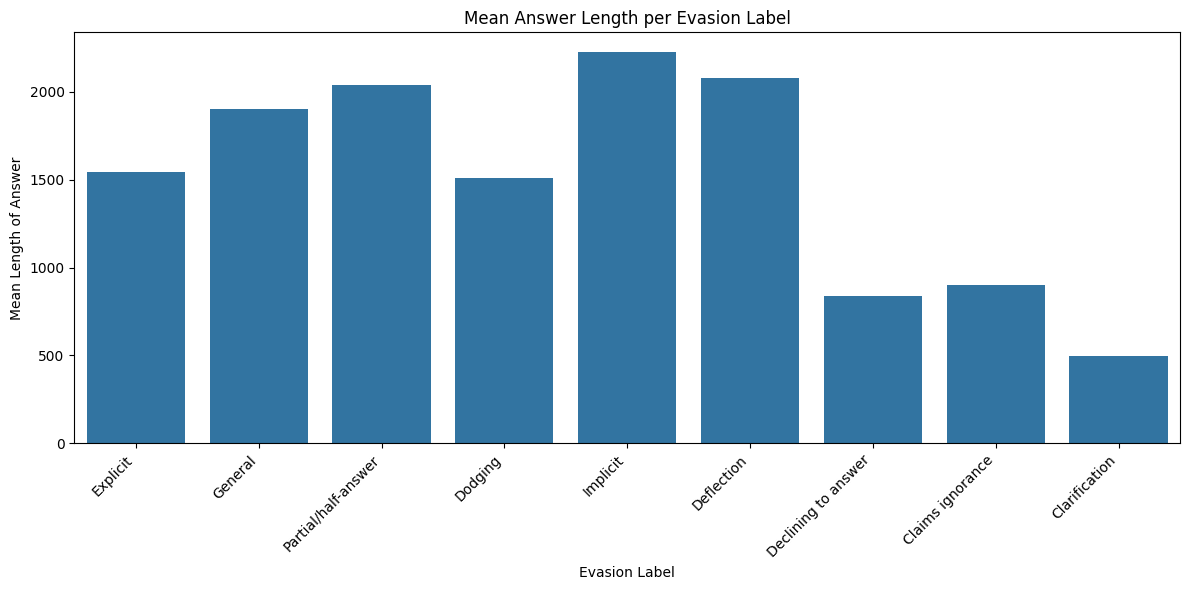

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting mean string length per evasion label
plt.figure(figsize=(12, 6))
sns.barplot(x=list(label_string_mean.keys()), y=list(label_string_mean.values()))
plt.title('Mean Answer Length per Evasion Label')
plt.xlabel('Evasion Label')
plt.ylabel('Mean Length of Answer')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Embeddings cossine similarity *


In [ ]:
# load model
try:
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2', device=device)
except ImportError:
    model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# COS similarity function
def calculate_similarity(df, q_col, a_col):
  questions = df[q_col].astype(str).tolist()
  answers = df[a_col].astype(str).tolist()

  q_embeddings = model.encode(questions, show_progress_bar=True, convert_to_numpy=True)
  a_embeddings = model.encode(answers, show_progress_bar=True, convert_to_numpy=True)

  dot_product = np.sum(q_embeddings * a_embeddings, axis=1)
  norm_q = np.linalg.norm(q_embeddings, axis=1)
  norm_a = np.linalg.norm(a_embeddings, axis=1)

  norm_q[norm_q == 0] = 1e-9
  norm_a[norm_a == 0] = 1e-9

  similarities = dot_product / (norm_q * norm_a)
  return similarities

In [ ]:
full_dataset['semantic_similarity'] = calculate_similarity(full_dataset, 'interview_question', 'interview_answer')

Batches:   0%|          | 0/108 [00:00<?, ?it/s]

Batches:   0%|          | 0/108 [00:00<?, ?it/s]

In [ ]:
print(full_dataset['semantic_similarity'].head())

0    0.531044
1    0.531044
2    0.553182
3    0.553182
4    0.474729
Name: semantic_similarity, dtype: float32


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

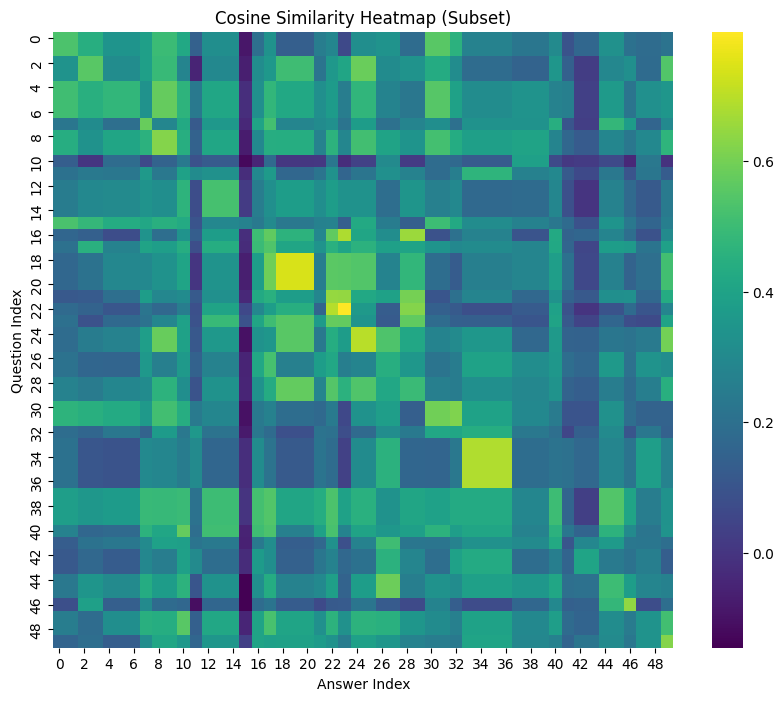

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

subset_df = full_dataset.head(50).copy()

subset_questions = subset_df['interview_question'].astype(str).tolist()
subset_answers = subset_df['interview_answer'].astype(str).tolist()

subset_q_embeddings = model.encode(subset_questions, show_progress_bar=True, convert_to_numpy=True)
subset_a_embeddings = model.encode(subset_answers, show_progress_bar=True, convert_to_numpy=True)

similarity_matrix = cosine_similarity(subset_q_embeddings, subset_a_embeddings)

plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=False, cmap='viridis', fmt=".2f")
plt.title('Cosine Similarity Heatmap (Subset)')
plt.xlabel('Answer Index')
plt.ylabel('Question Index')
plt.show()

Sentiment analysis *

In [ ]:
sia = SentimentIntensityAnalyzer()
def sentiment_analysis_question(dataset):
  return sia.polarity_scores(dataset['interview_question'])
def sentiment_analysis_answer(dataset):
  return sia.polarity_scores(dataset['interview_answer'])

In [ ]:
full_dataset['question_sentiment'] = full_dataset.apply(sentiment_analysis_question, axis=1)
full_dataset['answer_sentiment'] = full_dataset.apply(sentiment_analysis_answer, axis=1)

In [ ]:
print(full_dataset['question_sentiment'].head())
print(full_dataset['answer_sentiment'].head())

0    {'neg': 0.044, 'neu': 0.839, 'pos': 0.117, 'co...
1    {'neg': 0.044, 'neu': 0.839, 'pos': 0.117, 'co...
2    {'neg': 0.249, 'neu': 0.675, 'pos': 0.076, 'co...
3    {'neg': 0.249, 'neu': 0.675, 'pos': 0.076, 'co...
4    {'neg': 0.147, 'neu': 0.823, 'pos': 0.03, 'com...
Name: question_sentiment, dtype: object
0    {'neg': 0.031, 'neu': 0.874, 'pos': 0.095, 'co...
1    {'neg': 0.031, 'neu': 0.874, 'pos': 0.095, 'co...
2    {'neg': 0.048, 'neu': 0.835, 'pos': 0.116, 'co...
3    {'neg': 0.048, 'neu': 0.835, 'pos': 0.116, 'co...
4    {'neg': 0.029, 'neu': 0.885, 'pos': 0.086, 'co...
Name: answer_sentiment, dtype: object


In [ ]:
# Extract individual sentiment scores for questions
full_dataset['question_neg'] = full_dataset['question_sentiment'].apply(lambda x: x['neg'])
full_dataset['question_neu'] = full_dataset['question_sentiment'].apply(lambda x: x['neu'])
full_dataset['question_pos'] = full_dataset['question_sentiment'].apply(lambda x: x['pos'])
full_dataset['question_compound'] = full_dataset['question_sentiment'].apply(lambda x: x['compound'])

# Extract individual sentiment scores for answers
full_dataset['answer_neg'] = full_dataset['answer_sentiment'].apply(lambda x: x['neg'])
full_dataset['answer_neu'] = full_dataset['answer_sentiment'].apply(lambda x: x['neu'])
full_dataset['answer_pos'] = full_dataset['answer_sentiment'].apply(lambda x: x['pos'])
full_dataset['answer_compound'] = full_dataset['answer_sentiment'].apply(lambda x: x['compound'])

print("Sentiment scores extracted.")
display(full_dataset[['question_neg', 'question_neu', 'question_pos', 'question_compound',
                      'answer_neg', 'answer_neu', 'answer_pos', 'answer_compound']].head())

Sentiment scores extracted.


,question_neg,question_neu,question_pos,question_compound,answer_neg,answer_neu,answer_pos,answer_compound
0,0.044,0.839,0.117,0.5661,0.031,0.874,0.095,0.9602
1,0.044,0.839,0.117,0.5661,0.031,0.874,0.095,0.9602
2,0.249,0.675,0.076,-0.8761,0.048,0.835,0.116,0.9152
3,0.249,0.675,0.076,-0.8761,0.048,0.835,0.116,0.9152
4,0.147,0.823,0.030,-0.8924,0.029,0.885,0.086,0.9581


In [ ]:
# Calculate average sentiment scores per evasion label
avg_sentiment_by_evasion = full_dataset.groupby('evasion_label')[['question_neg', 'question_neu', 'question_pos', 'question_compound',
                                                                 'answer_neg', 'answer_neu', 'answer_pos', 'answer_compound']].mean()

print("Average sentiment scores per evasion label:")
display(avg_sentiment_by_evasion)

Average sentiment scores per evasion label:


,question_neg,question_neu,question_pos,question_compound,answer_neg,answer_neu,answer_pos,answer_compound
evasion_label,,,,,,,,
Claims ignorance,0.073857,0.856126,0.070017,0.007124,0.041168,0.829513,0.129311,0.542450
Clarification,0.050620,0.879902,0.069478,0.132985,0.043391,0.865696,0.090913,0.161915
Declining to answer,0.058634,0.864903,0.076476,0.155890,0.040786,0.831497,0.127710,0.389092
Deflection,0.058066,0.855979,0.085992,0.152524,0.054451,0.810000,0.135562,0.627640
Dodging,0.057975,0.856977,0.085035,0.177253,0.056054,0.779497,0.164432,0.516029
Explicit,0.055315,0.857914,0.086765,0.157430,0.068285,0.757051,0.174654,0.530867
General,0.049803,0.860720,0.089461,0.181624,0.052280,0.806365,0.141355,0.641330
Implicit,0.057709,0.856691,0.085574,0.160079,0.057449,0.810828,0.131748,0.615271
Partial/half-answer,0.049709,0.859506,0.090785,0.254842,0.055608,0.797810,0.146608,0.714038


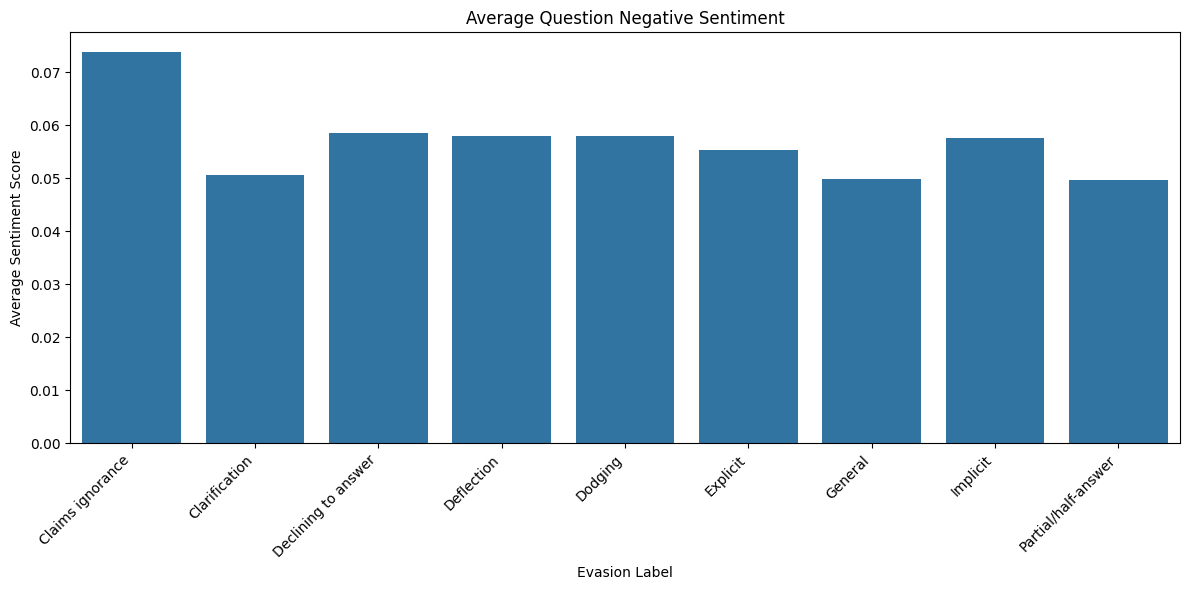

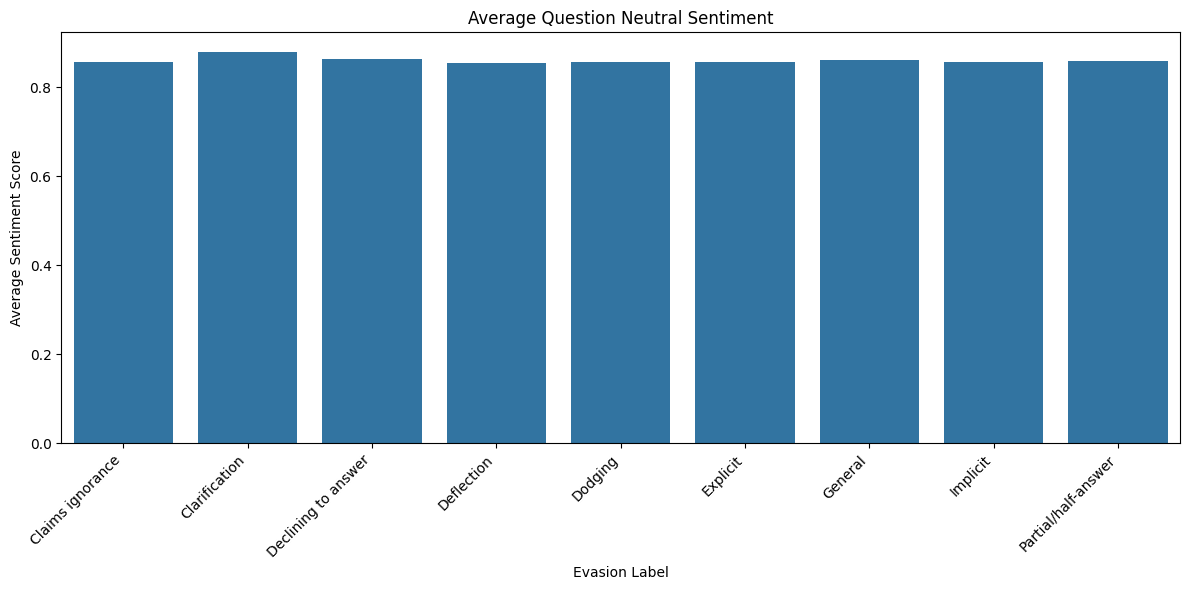

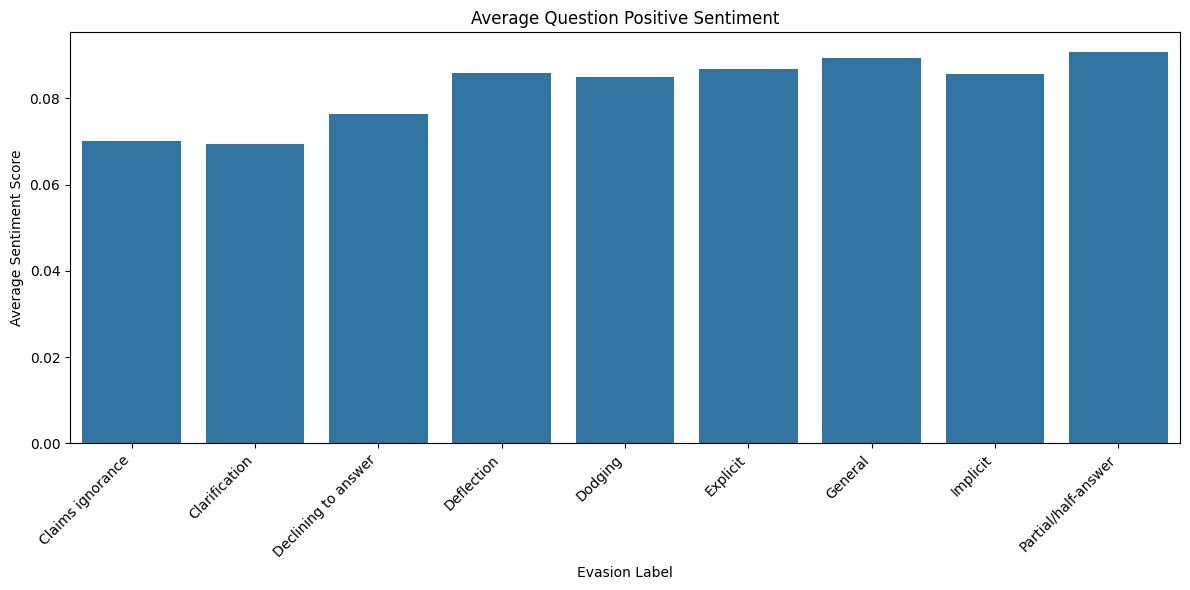

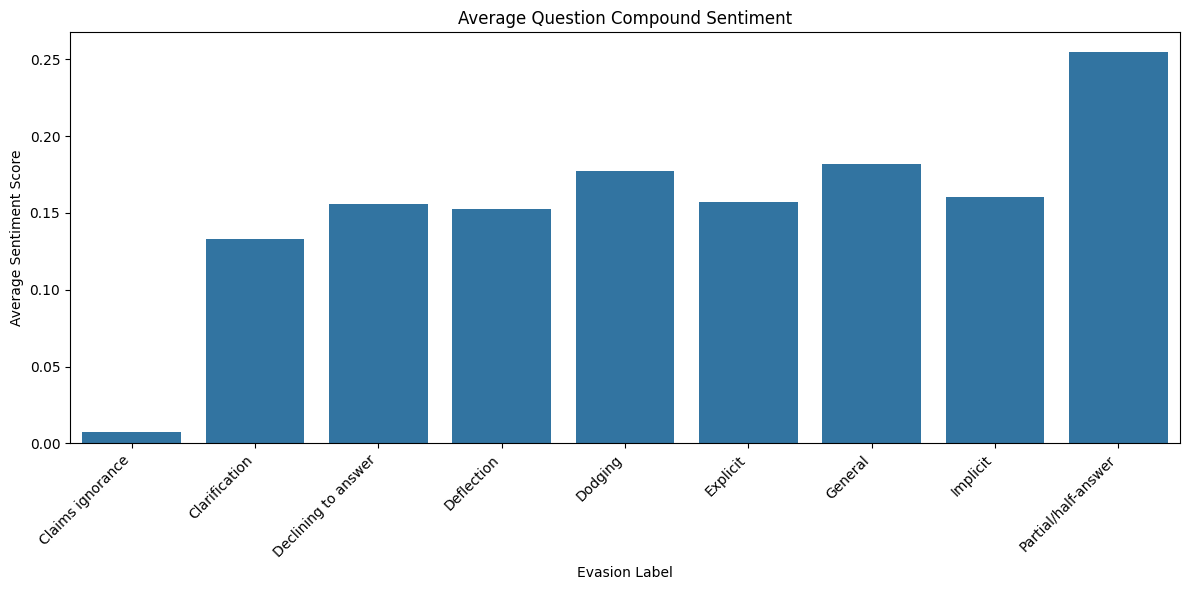

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting average question sentiment scores per evasion label
sentiment_scores = ['question_neg', 'question_neu', 'question_pos', 'question_compound']
titles = ['Average Question Negative Sentiment', 'Average Question Neutral Sentiment', 'Average Question Positive Sentiment', 'Average Question Compound Sentiment']

for i, score in enumerate(sentiment_scores):
    plt.figure(figsize=(12, 6))
    sns.barplot(x=avg_sentiment_by_evasion.index, y=avg_sentiment_by_evasion[score])
    plt.title(titles[i])
    plt.xlabel('Evasion Label')
    plt.ylabel('Average Sentiment Score')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

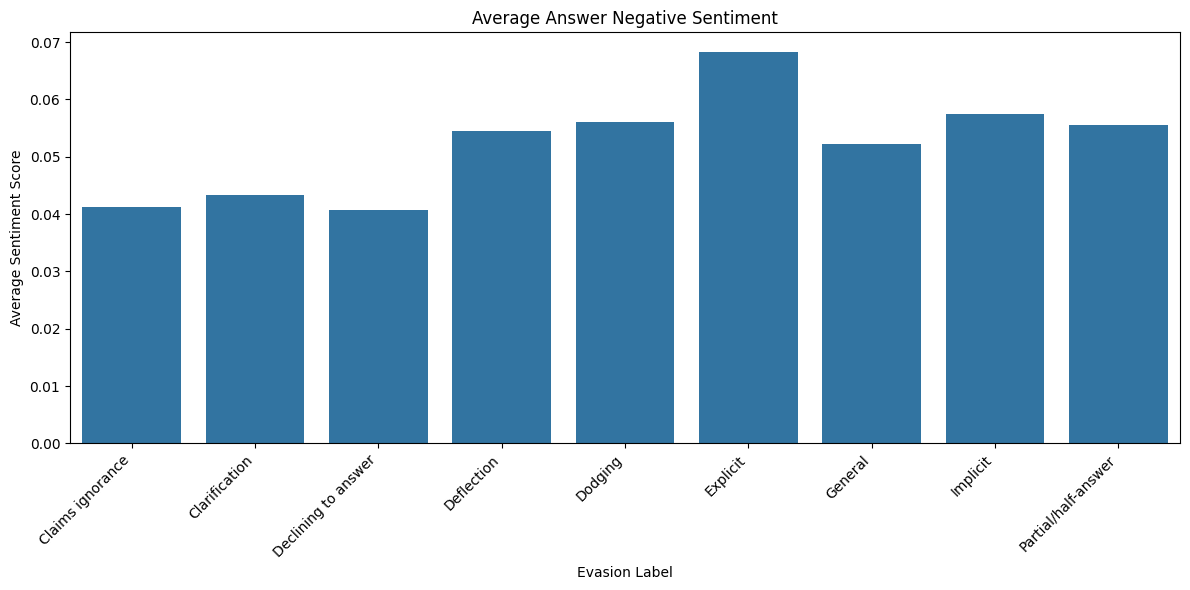

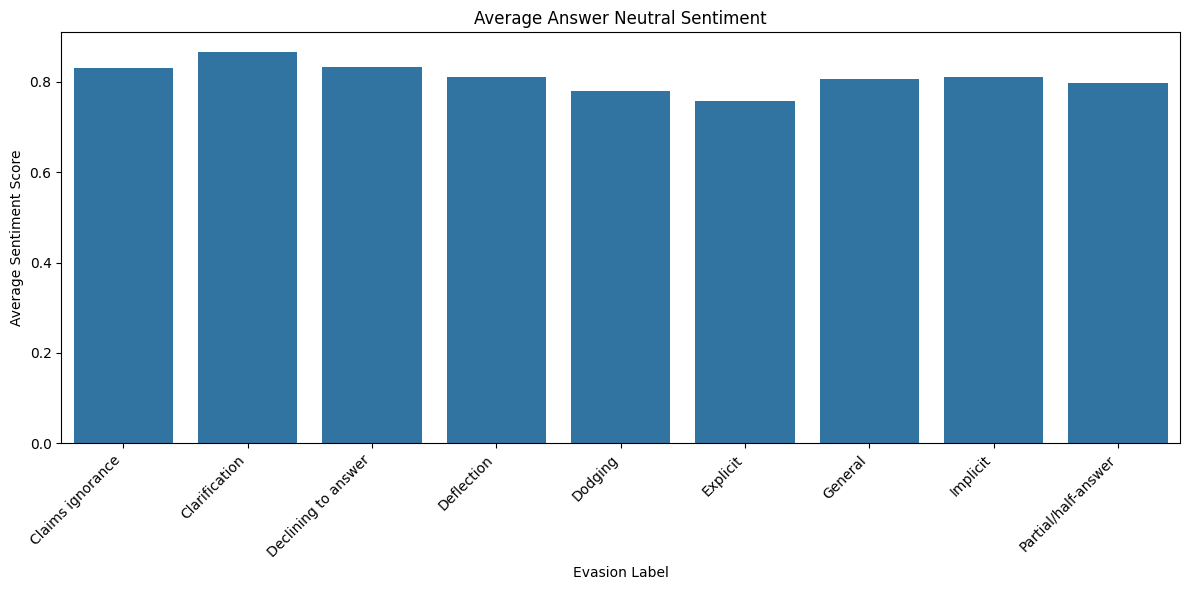

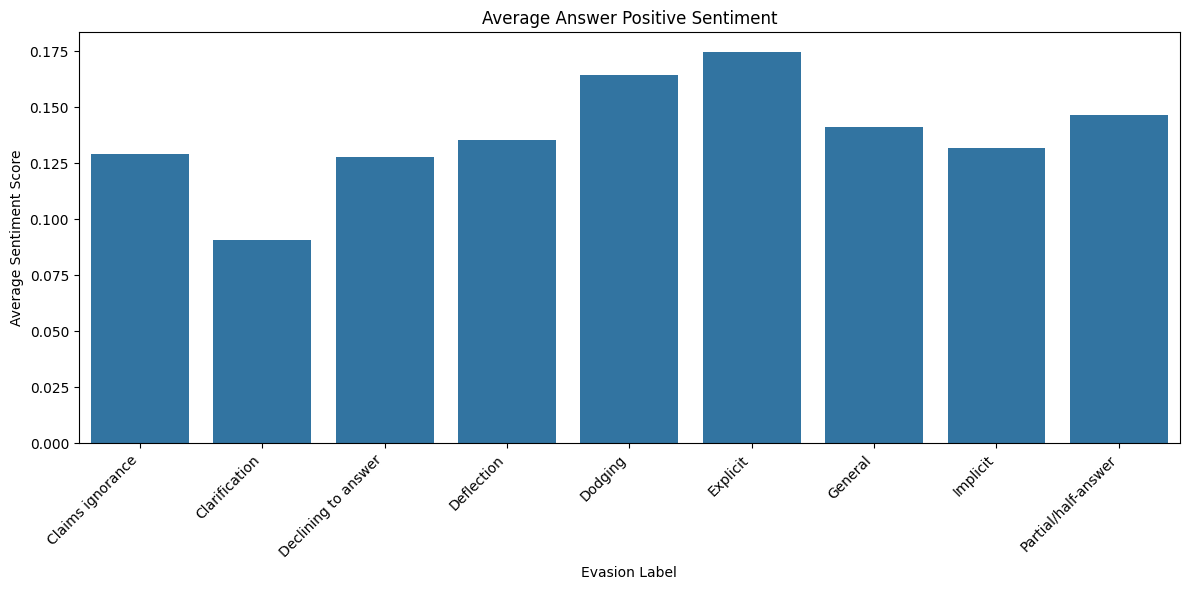

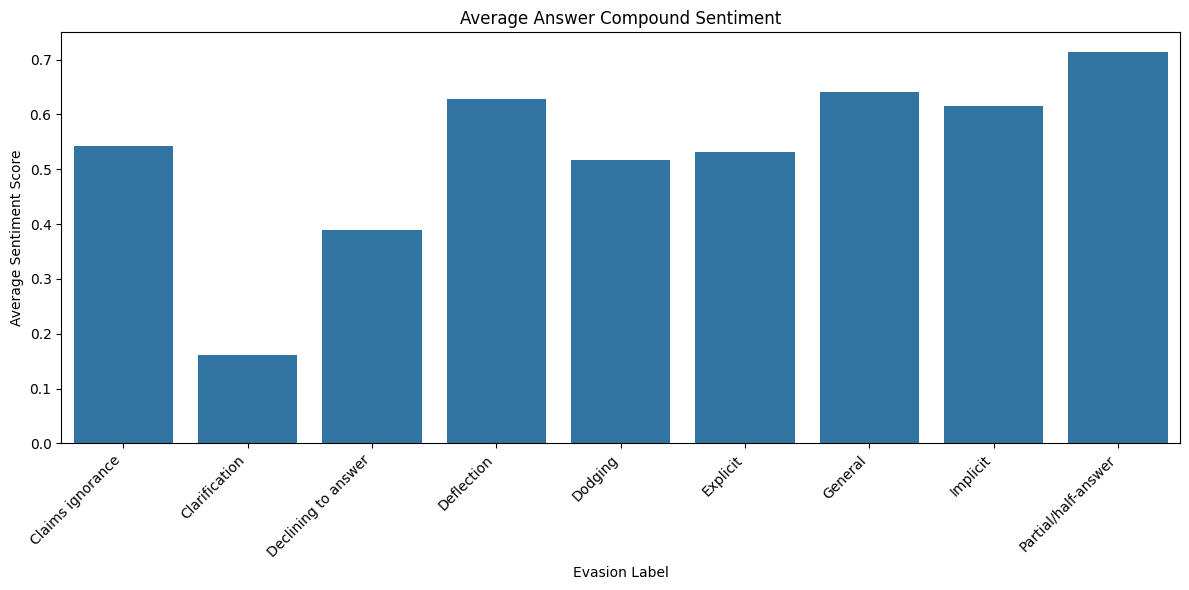

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting average answer sentiment scores per evasion label
sentiment_scores = ['answer_neg', 'answer_neu', 'answer_pos', 'answer_compound']
titles = ['Average Answer Negative Sentiment', 'Average Answer Neutral Sentiment', 'Average Answer Positive Sentiment', 'Average Answer Compound Sentiment']

for i, score in enumerate(sentiment_scores):
    plt.figure(figsize=(12, 6))
    sns.barplot(x=avg_sentiment_by_evasion.index, y=avg_sentiment_by_evasion[score])
    plt.title(titles[i])
    plt.xlabel('Evasion Label')
    plt.ylabel('Average Sentiment Score')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

Counting sentence fillers & hedges *

In [ ]:
def count_fillers(dataset):
  text=dataset['interview_answer']

  filler_list = [
    # Vocal fillers
    'um', 'uh', 'ah', 'er', 'erm',
    # Common phrase fillers
    'like', 'you know', 'so', 'well', 'right',
    'actually', 'basically', 'literally', 'okay',
    # Common hedges
    'i think', 'i guess', 'i mean', 'i suppose',
    'kind of', 'sort of', 'let\'s say', 'maybe',
    'probably', 'in a way', 'you see'
  ]

  normalized_text = text.lower()
  filler_list.sort(key=len, reverse=True)

  patterns = []

  for filler in filler_list:
    if ' ' in filler:
      patterns.append(re.escape(filler))
    else:
      patterns.append(r'\b' + re.escape(filler) + r'\b')

  regex_pattern = '|'.join(patterns)
  matches = re.findall(regex_pattern, normalized_text)
  #counts = Counter(matches)

  return len(matches)#dict(counts)

In [ ]:
full_dataset['count_fillers'] = full_dataset.apply(count_fillers, axis=1)

In [ ]:
label_fillers_mean=dict()

for label in labels_evasion_list:
  target_dataset=full_dataset[full_dataset['evasion_label']==label].copy()
  target_dataset['contagem']=target_dataset['count_fillers']
  label_fillers_mean[label]=target_dataset['contagem'].sum()/len(target_dataset['contagem'])
  print(f"mean of {label} = {label_fillers_mean[label]}")

print(label_fillers_mean)

mean of Explicit = 6.354562737642586
mean of General = 7.536269430051814
mean of Partial/half-answer = 8.0
mean of Dodging = 5.808781869688385
mean of Implicit = 8.692622950819672
mean of Deflection = 8.506561679790027
mean of Declining to answer = 3.806896551724138
mean of Claims ignorance = 4.151260504201681
mean of Clarification = 1.8369565217391304
{'Explicit': np.float64(6.354562737642586), 'General': np.float64(7.536269430051814), 'Partial/half-answer': np.float64(8.0), 'Dodging': np.float64(5.808781869688385), 'Implicit': np.float64(8.692622950819672), 'Deflection': np.float64(8.506561679790027), 'Declining to answer': np.float64(3.806896551724138), 'Claims ignorance': np.float64(4.151260504201681), 'Clarification': np.float64(1.8369565217391304)}


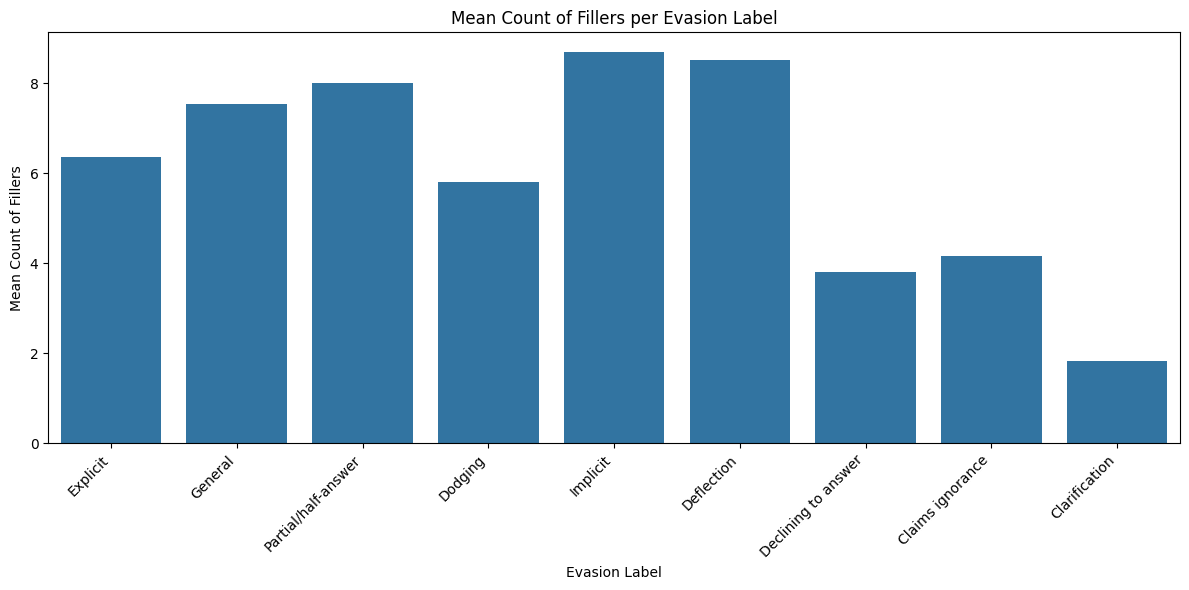

In [ ]:
# Plotting mean count of fillers per evasion label
plt.figure(figsize=(12, 6))
sns.barplot(x=list(label_fillers_mean.keys()), y=list(label_fillers_mean.values()))
plt.title('Mean Count of Fillers per Evasion Label')
plt.xlabel('Evasion Label')
plt.ylabel('Mean Count of Fillers')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()